# Does Clinton have a 98% chance of winning?
## Finding biases (or inefficiencies) in election prediction markets

PredictIt has several prediction markets [for the general election](https://www.predictit.org/Browse/Group/67/National). The probabilities among all are roughly equivilent. However, it also has a market for every state.

Now, what if we took each state's prediction market, and used it to simulate general elections? If the market is efficient, we would predict the mean of all simulated elections *not* to differ from the mean of the existing election markets.

## Simulating the election with market-derived probabilities
First, we'll get a prediction market from each state on PredictIt.

PredictIt has a Republican and Democratic market for each state election, with each market having its own yes/no. The odds on an outcome may be slightly different between markets (more on this below). 

In [60]:
!pip install requests
%pylab inline
import requests 
import json

def request_json (url):
    return json.loads(
           requests.get(url, headers={
            'Accept':'application/json'}).content)

my_url = 'https://www.predictit.org/api/marketdata/ticker/RNOM16'
request_json(my_url)

def predictit (ticker):
    return request_json('https://www.predictit.org/api/marketdata/ticker/' + ticker)

def market (state_abbreviation, party):
    api_res = predictit('DEM.'+state_abbreviation+'.USPREZ16')
    contracts = api_res['Contracts']
    contract = filter(lambda c: c['ShortName']==party, contracts)[0]
    return contract

# market('CA', 'Republican')

Populating the interactive namespace from numpy and matplotlib



We need to turn the prediction market prices into probabilities. Following [Rothschild, 2009](http://researchdmr.com/RothschildPOQ2009.pdf):

> First, I take the average of the bid and ask for the stock that pays out if the Democrat wins on Election Day. If the bid-ask spread is greater than five points, I take the last sale price. If there are no active offers and no sales in the last two weeks of the race, I drop the race.

We can do this separately for both Democratic and Republican markets. We'll focus on the Clinton win outcome, corresponding to a yes in the Democratic markets and a No in the Republican markets.

We should also debias this probability. Following Leigh et al. (2007) *Is There a Favorite-Longshot Bias in Election Markets?*, Rothschild (2009) suggests `Pr = theta(1.64*theta^-1(price))`. 

*Limitations*: I don't have programmatic access to historical trade data, So I cannot find date of last sale. Consequently, no races are dropped here. Without historical trade data, I also can't find a value for [theta](http://www.investopedia.com/terms/t/theta.asp) so these values are not debiased. **If anyone has access to historical PredictIt data, or historical data from any prediction market, please contact me**:

`ffff [at] berkeley [] edu`

In the meantime, we'll make share prices into probabilities as best we can:



In [21]:
def probability (state_abbreviation, party=None):
    # Average both party markets by default
    if (party is None):
       return (probability(state_abbreviation, 'Democratic') +
              probability(state_abbreviation, 'Republican'))/2
    mkt = market(state_abbreviation, party)
    # For republican markets, get the No cost
    if (party=='Republican'):
       sell = mkt['BestSellNoCost']
       buy = mkt['BestBuyNoCost']
    # For democratic markets, get the "Yes cost
    elif (party=='Democratic'):
       sell = mkt['BestSellYesCost']
       buy = mkt['BestBuyYesCost']
    # If the spread is > 5
    spread = buy-sell
    if (sell > 5):
       # Just use the last trade price
       return mkt['LastTradePrice']
    return (sell+buy)/2.0

probability('CA')


0.9524999999999999

Now, we'll construct a list of all `states`, where each state has a `probability` of a Clinton win, and a number of `delegates`.

In [30]:
def state (abbrev, delegates):
    return {"abbreviation": abbrev,
           "delegates": delegates,
           "probability": probability(abbrev),}

states_delegates = {'AL':9, 'AK':3, 'AZ':11, 'AR':6, 'CA':55, 'CO':9, 'CT':7, 'DC':3, 'DE':3, 'FL':29, 'GA':16, 'HI':4, 'ID':4, 'IL':20, 'IN':11, 'IA':6, 'KS':6, 'KY':8, 'LA':8, 'ME':4, 'MD':10, 'MA':11, 'MI':16, 'MN':10, 'MS':6, 'MO':10, 'MT':3, 'NE':5, 'NV':6, 'NH':4, 'NJ':14, 'NM':5, 'NY':29, 'NC':15, 'ND':3, 'OH':18, 'OK':7, 'OR':7, 'PA':20, 'RI':4, 'SC':9, 'SD':3, 'TN':11, 'TX':38, 'UT':6, 'VT':3, 'VA':13, 'WA':12, 'WV':5, 'WI':10, 'WY':3,} 
print 'sanity check - delegates add up to 538?', 538 == sum([val for key, val in states_delegates.iteritems()])

states = [state(key,val) for key, val in states_delegates.iteritems()]


sanity check - delegates add up to 538? True


Now we can start to simulate elections. We'll use each probability to allocate delegates, or not, to Clinton. We'll do this some number of times, producing a list of Clinton delegates elected in each simulation.

In [53]:
import random
random.seed()

def decide (probability):
    return random.random()<probability
    
def allocate_delegates (state):
    '''
    Simulates an election in the state.
    Uses probabilty derived from `party`
    Returns a number of delegates allocated to dems (0 if party loss).
    '''
    return state['delegates'] * decide(state['probability'])

def simulate_election (_):
    '''
    Return number of delegates for Clinton.
    '''
    return sum(map(allocate_delegates, states))
    
def simulate_elections (trials):
    return map(simulate_election, range(trials))
    
num_trials = 100000
simulations = simulate_elections(num_trials)
print 'simulated ' + str(num_trials) + ' elections'

simulated 100000 elections


Now we can calculate how many of those elections Clinton won. We will count only majority wins. Electoral deadlocks will count as a loss.

In [54]:
def winning (delegates):
    return delegates > 270

win_percent = float(len(filter(winning, simulations)))/float(num_trials)

print '% elections won by Clinton: ' + str(win_percent)

% elections won by Clinton: 0.97656


Here's a distribution of the number of delegates Clinton gets in each election. The blue line represents the 270 delegates needed to win the electoral college.

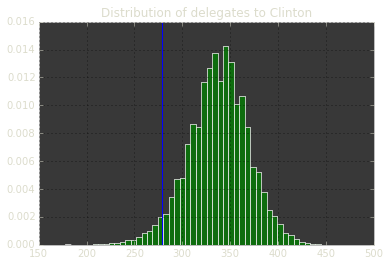

In [55]:
plt.title('Distribution of delegates to Clinton')
plt.hist(simulations, 50, normed=1, facecolor='green', alpha=0.75)
plt.axvline(x=279)


# Something doesn't add up. Where are the biases?

Our estimated 97% chance of a Clinton win is significantly higher than the PredictIt general election market (which has about 82¢ for Clinton shares as of 10-16-16). It is also much higher than Rothchild's [debiased aggregate](http://predictwise.com/). Are the general markets not bullish enough on Clinton, or are the state markets too bullish on Clinton?

Let's assume that the national election markets, and poll-based forecasts, are roughly correct. What would it mean for the state markets to undervalue a Clinton win? Well, let's take a look at those states where market prices have an estimated 20% to 50% chance of a Clinton win.

In [58]:
filter(lambda s: s['probability']<0.5 and s['probability']>0.2, states)

[{'abbreviation': 'GA', 'delegates': 16, 'probability': 0.27},
 {'abbreviation': 'AK', 'delegates': 3, 'probability': 0.21000000000000002},
 {'abbreviation': 'AZ', 'delegates': 11, 'probability': 0.4875},
 {'abbreviation': 'UT', 'delegates': 6, 'probability': 0.225},
 {'abbreviation': 'MO', 'delegates': 10, 'probability': 0.2025}]

In [0]:
Excluding Utah, which has a [non-negligable chance of a 3rd-party win](http://www.nytimes.com/2016/10/15/us/politics/evan-mcmullin-campaign-utah.html?_r=0), these other states 